In [4]:
from matplotlib import pyplot as plt
import numpy as np
import time
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from pandas.io.json import json_normalize
import functools
import json

import warnings
warnings.filterwarnings('ignore')

In [28]:
database = {
    'singlechanneljson': "SELECT * FROM timescaledbapp_singlechanneljson LIMIT {LIMIT}",
    'singlechannelfloat': "SELECT * FROM timescaledbapp_singlechannelfloat LIMIT {LIMIT}",    
    'multichanneljson': "SELECT * FROM timescaledbapp_multichanneljson LIMIT {LIMIT}",
    'multichannelfloat': "SELECT * FROM timescaledbapp_multichannelfloat LIMIT {LIMIT}",
    
    
    'firstsinglechannelfloat': "SELECT time, data FROM timescaledbapp_singlechannelfloat LIMIT {LIMIT}",  
    'firstmultichannelfloat': "SELECT time, data1 FROM timescaledbapp_multichannelfloat LIMIT {LIMIT}", 
}

In [6]:
@functools.lru_cache(maxsize=10000)
def get(model, limit, verbose=False):
    
    t0 = time.time()
    engine = psycopg2.connect(
        host="localhost",
        database="dunderlab_timescale_v1",
        user="postgres",
        password="password",
        port='5432',
    )
    
    df = pd.read_sql_query(database[model].format(LIMIT=limit), engine, index_col="time")
    engine.close()
    t1 = time.time()
    
    if verbose:
        print(f'{model}: {len(df.columns)} columns')
        return df
    
    return t1 - t0


@functools.lru_cache(maxsize=10000)
def get_(model, limit):
    
    engine = psycopg2.connect(
        host="localhost",
        database="dunderlab_timescale_v1",
        user="postgres",
        password="password",
        port='5432',
    )
    
    df = pd.read_sql_query(database[model].format(LIMIT=limit), engine, index_col="time")
    engine.close()
    return df


@functools.lru_cache(maxsize=10000)
def json2float(model, n=100):
    t0 = time.time()
    df = get_(model, n)
    df = df['data'].apply(lambda x: pd.Series(eval(x)))
    t1 = time.time()
    return t1 - t0

In [7]:
[get(_, 1, verbose=True) for _ in database.keys()];

singlechanneljson: 2 columns
singlechannelfloat: 2 columns
multichanneljson: 2 columns
multichannelfloat: 65 columns


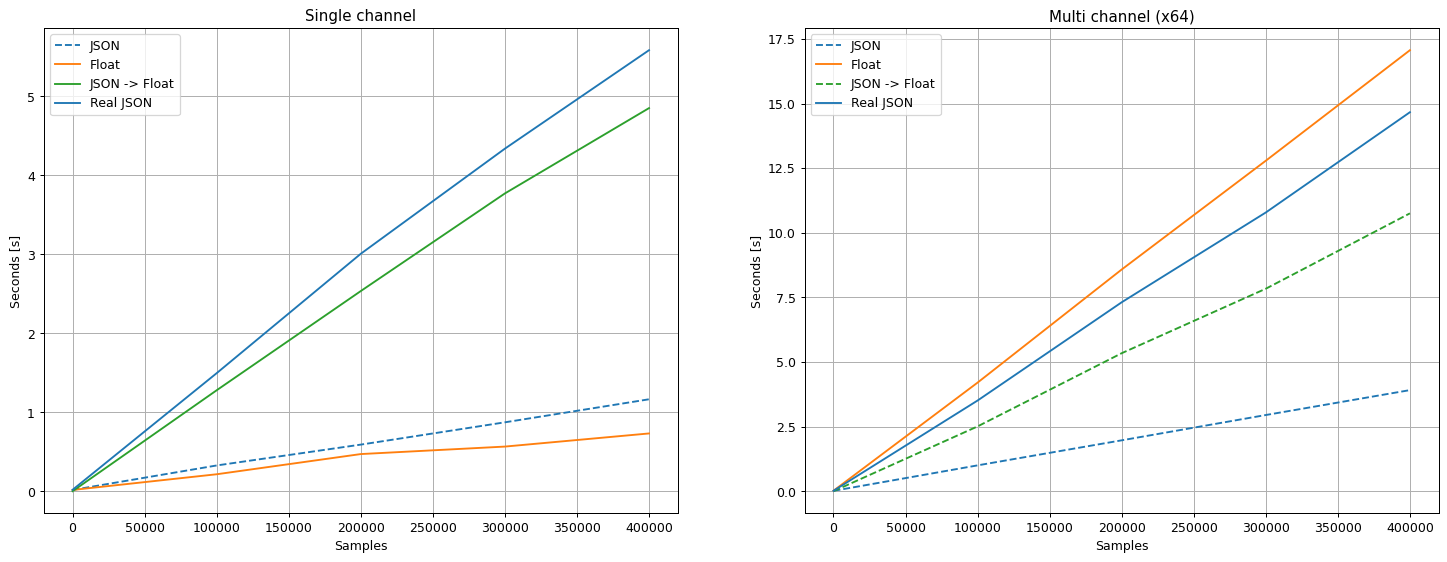

In [52]:
x = range(0, 500000, 100000)
cores = 8

plt.figure(figsize=(20, 7), dpi=90)


singlechanneljson = np.array([get('singlechanneljson', i) for i in x])
singlechannelfloat = np.array([get('singlechannelfloat', i) for i in x])
singlechanneljson2float = np.array([json2float('singlechanneljson', i) for i in x])/cores
multichanneljson = np.array([get('multichanneljson', i) for i in x])
multichannelfloat = np.array([get('multichannelfloat', i) for i in x])
multichanneljson2float = np.array([json2float('multichanneljson', i) for i in x])/cores
    
    
plt.subplot(121)
plt.title('Single channel')
plt.plot(x, singlechanneljson, '--', color='C0', label='JSON')
plt.plot(x, singlechannelfloat, '-', color='C1', label='Float')
plt.plot(x, singlechanneljson2float, '-', color='C2', label='JSON -> Float')
plt.plot(x, singlechannelfloat + singlechanneljson2float, '-', color='C0', label='Real JSON')
plt.legend()
plt.ylabel('Seconds [s]')
plt.xlabel('Samples')
plt.grid(True)

plt.subplot(122)
plt.title('Multi channel (x64)')
plt.plot(x, multichanneljson, '--', color='C0', label='JSON')
plt.plot(x, multichannelfloat, '-', color='C1', label='Float')
plt.plot(x, multichanneljson2float, '--', color='C2', label='JSON -> Float')
plt.plot(x, multichanneljson + multichanneljson2float, '-', color='C0', label='Real JSON')
plt.legend()
plt.ylabel('Seconds [s]')
plt.xlabel('Samples')
plt.grid(True)

plt.savefig('singlevsmulti.png')

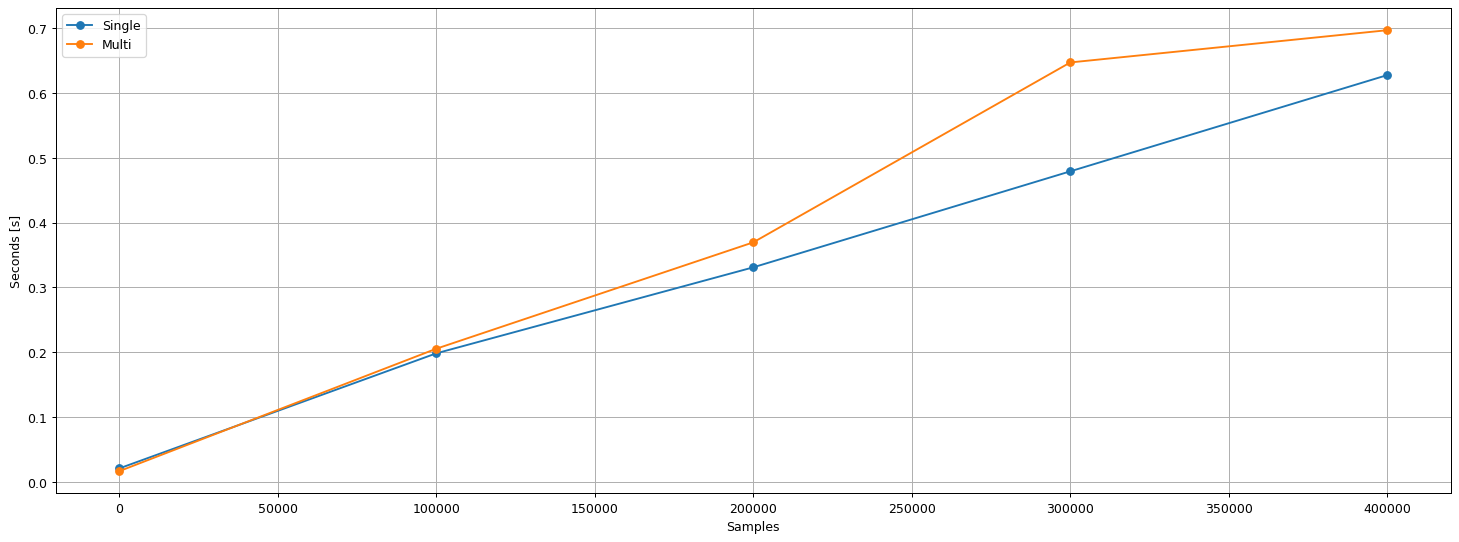

In [53]:
x = range(0, 500000, 100000)

plt.figure(figsize=(20, 7), dpi=90)

plt.plot(x, np.array([get('firstsinglechannelfloat', i) for i in x]), '-o', color='C0', label='Single')
plt.plot(x, np.array([get('firstmultichannelfloat', i) for i in x]), '-o', color='C1', label='Multi')

plt.legend()
plt.ylabel('Seconds [s]')
plt.xlabel('Samples')
plt.grid(True)

plt.savefig('singlevssinglemulti.png')

In [6]:
ROLES = ('admin', 'generator', 'consumer', 'produser')
ROLES = [(rol, rol.capitalize()) for rol in ROLES]
ROLES

[('admin', 'Admin'),
 ('generator', 'Generator'),
 ('consumer', 'Consumer'),
 ('produser', 'Produser')]